### Imports

In [6]:
# Install once if needed
# !pip install networkx matplotlib pandas scikit-learn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Load Fraud Network Dataset

In [7]:
df = pd.read_csv("fraud_network_50000.csv")

print("Shape:", df.shape)
df.head()

Shape: (50000, 16)


,beneficiary_id,aadhaar_like_id,name,household_id,district,phone_number,bank_account,agent_id,registration_day,phone_degree,bank_degree,household_size,agent_cluster_size,is_duplicate,fraud_ring_member,is_master_agent
0,B000000,100000015795,Priya,HH24063,District_19,9820019110,BA97523830,AG0550,154,1,3,1,12,1,1,1
1,B000001,100000000860,Sneha,HH11793,District_10,9294445623,BA74975266,AG2523,75,1,1,1,12,1,1,1
2,B000002,100000038158,Vikram,HH17712,District_16,9684589693,BA35160821,AG3712,205,2,2,2,15,1,1,1
3,B000003,100000044732,Pooja,HH11456,District_4,9333105192,BA47796442,AG2506,328,3,2,2,9,1,1,0
4,B000004,100000011284,Pooja,HH25453,District_6,9567801705,BA19682218,AG2307,137,3,2,2,13,1,1,1


### Create Graph

In [8]:
G = nx.Graph()

# Add nodes
for _, row in df.iterrows():
    G.add_node(row["beneficiary_id"])

### Add Edges Based on Shared Features

In [9]:
def add_edges_by_column(column):
    grouped = df.groupby(column)["beneficiary_id"].apply(list)

    for beneficiaries in grouped:
        if len(beneficiaries) > 1:
            for i in range(len(beneficiaries)):
                for j in range(i + 1, len(beneficiaries)):
                    G.add_edge(beneficiaries[i], beneficiaries[j])


# Create edges from shared infrastructure
for col in ["phone_number", "bank_account", "agent_id", "aadhaar_like_id"]:
    add_edges_by_column(col)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 50000
Edges: 348328


### Connected Components

In [10]:
components = list(nx.connected_components(G))

# Map beneficiary → component size
component_size_map = {}

for comp in components:
    size = len(comp)
    for node in comp:
        component_size_map[node] = size

df["graph_component_size"] = df["beneficiary_id"].map(component_size_map)

### Predict Fruad Ring via Graph

In [11]:
df["graph_fraud_ring_pred"] = (df["graph_component_size"] >= 5).astype(int)


### Compute Centrality

In [12]:
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, k=200, seed=42)  # sampled for speed

df["degree_centrality"] = df["beneficiary_id"].map(degree_centrality)
df["betweenness"] = df["beneficiary_id"].map(betweenness)

### Master Agent Prediction Rule

In [13]:
degree_threshold = df["degree_centrality"].quantile(0.95)

df["graph_master_agent_pred"] = (
    (df["degree_centrality"] >= degree_threshold) &
    (df["graph_fraud_ring_pred"] == 1)
).astype(int)


### Fruad Ring Evaluation

In [14]:
print("Fraud Ring Detection Accuracy:")
print(accuracy_score(df["fraud_ring_member"], df["graph_fraud_ring_pred"]))

print("\nConfusion Matrix:")
print(confusion_matrix(df["fraud_ring_member"], df["graph_fraud_ring_pred"]))

print("\nClassification Report:")
print(classification_report(df["fraud_ring_member"], df["graph_fraud_ring_pred"]))

Fraud Ring Detection Accuracy:
0.99242

Confusion Matrix:
[[    0   379]
 [    0 49621]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       379
           1       0.99      1.00      1.00     49621

    accuracy                           0.99     50000
   macro avg       0.50      0.50      0.50     50000
weighted avg       0.98      0.99      0.99     50000



d:\All_Projects\Prayatna\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\All_Projects\Prayatna\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\All_Projects\Prayatna\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Master Agent Evaluation

In [15]:
print("Master Agent Detection Accuracy:")
print(accuracy_score(df["is_master_agent"], df["graph_master_agent_pred"]))

print("\nConfusion Matrix:")
print(confusion_matrix(df["is_master_agent"], df["graph_master_agent_pred"]))

print("\nClassification Report:")
print(classification_report(df["is_master_agent"], df["graph_master_agent_pred"]))

Master Agent Detection Accuracy:
0.4044

Confusion Matrix:
[[16607     2]
 [29778  3613]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53     16609
           1       1.00      0.11      0.20     33391

    accuracy                           0.40     50000
   macro avg       0.68      0.55      0.36     50000
weighted avg       0.79      0.40      0.31     50000



### Extract Largest Fraud Component

In [16]:
largest_component = max(components, key=len)

sub_nodes = list(largest_component)[:50]  # limit for plotting
subgraph = G.subgraph(sub_nodes)

### Plot Fraud Network

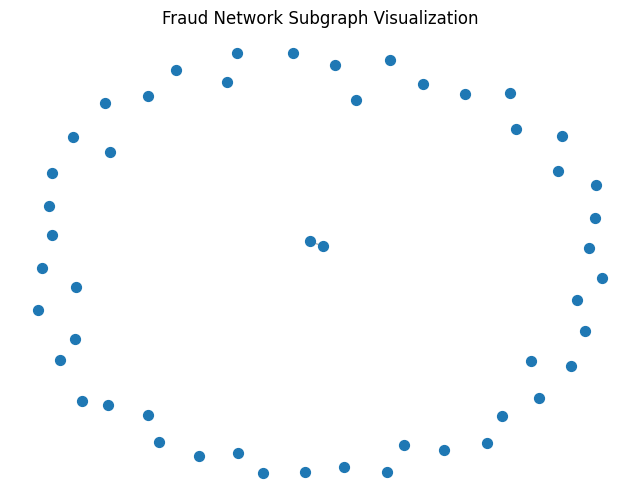

In [17]:
plt.figure(figsize=(8, 6))

pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_size=50)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)

plt.title("Fraud Network Subgraph Visualization")
plt.axis("off")
plt.show()